# Analisi della valutazione del valore dei giocatori di calcio

## Progetto "Laboratorio di Big Data"  di Marco Cossu   11/82/00211

### Inizializzazione SparkSession

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, format_number
import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

In [2]:
spark_context = spark.sparkContext

In [3]:
spark = SparkSession.builder.appName("Soccer_Players_Value_Analysis").getOrCreate()

## Importazione Dataset e Rappresentazione Variabili

In [4]:
dataset = (r"C:\Users\marco\Desktop\Università\Laboratorio di Big Data\FIFA_Players_Dataset.csv")
df = spark.read.csv(dataset, sep =',', inferSchema=True, header=True)

In [5]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- full_name: string (nullable = true)
 |-- birth_date: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- height_cm: double (nullable = true)
 |-- weight_kgs: double (nullable = true)
 |-- positions: string (nullable = true)
 |-- nationality: string (nullable = true)
 |-- overall_rating: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_euro: double (nullable = true)
 |-- wage_euro: double (nullable = true)
 |-- preferred_foot: string (nullable = true)
 |-- international_reputation(1-5): integer (nullable = true)
 |-- weak_foot(1-5): integer (nullable = true)
 |-- skill_moves(1-5): integer (nullable = true)
 |-- work_rate: string (nullable = true)
 |-- body_type: string (nullable = true)
 |-- release_clause_euro: double (nullable = true)
 |-- club_team: string (nullable = true)
 |-- club_rating: double (nullable = true)
 |-- club_position: string (nullable = true)


## Feature Selection

#### Vengono eliminate alcune variabili in quanto non utili per l'analisi in corso o di tipo string e, quindi, non utilizzabili  

In [6]:
df_log = df.withColumn("Log_Market_Value", F.log10(F.col('value_euro')))
df_plain = df.withColumn('Market_Value_in_Million', df["value_euro"]/1000000)

In [7]:
cols = ("id","full_name","potential","birth_date","positions","nationality","wage_euro","club_team","club_position","club_jersey_number",
        "club_join_date","national_team","national_team_position","national_jersey_number",
       "tags","traits","LS","ST","RS","LW","LF","CF","RF","RW","LAM","CAM","RAM","LM","LCM","CM","RCM","RM",
       "LWB","LDM","CDM","RDM","RWB","LB","LCB","CB","RCB","RB","value_euro","contract_end_year",'work_rate',
        'body_type',"body_type","release_clause_euro")
df_log = df_log.drop(*cols)
df_plain = df_plain.drop(*cols)

In [8]:
features_log = [col for col in df_log.columns if col not in ('name',"preferred_foot")] 
features_plain = [col for col in df_plain.columns if col not in ('name',"preferred_foot")] 

In [9]:
df_log.head()

Row(name='L. Messi', age=31, height_cm=170.18, weight_kgs=72.1, overall_rating=94, preferred_foot='Left', international_reputation(1-5)=5, weak_foot(1-5)=4, skill_moves(1-5)=4, club_rating=86.0, national_rating=82.0, crossing=86, finishing=95, heading_accuracy=70, short_passing=92, volleys=86, dribbling=97, curve=93, freekick_accuracy=94, long_passing=89, ball_control=96, acceleration=91, sprint_speed=86, agility=93, reactions=95, balance=95, shot_power=85, jumping=68, stamina=72, strength=66, long_shots=94, aggression=48, interceptions=22, positioning=94, vision=94, penalties=75, composure=96, marking=33, standing_tackle=28, sliding_tackle=26, GK_diving=6, GK_handling=11, GK_kicking=15, GK_positioning=14, GK_reflexes=8, Log_Market_Value=8.04336227802113)

In [10]:
df_plain.head()

Row(name='L. Messi', age=31, height_cm=170.18, weight_kgs=72.1, overall_rating=94, preferred_foot='Left', international_reputation(1-5)=5, weak_foot(1-5)=4, skill_moves(1-5)=4, club_rating=86.0, national_rating=82.0, crossing=86, finishing=95, heading_accuracy=70, short_passing=92, volleys=86, dribbling=97, curve=93, freekick_accuracy=94, long_passing=89, ball_control=96, acceleration=91, sprint_speed=86, agility=93, reactions=95, balance=95, shot_power=85, jumping=68, stamina=72, strength=66, long_shots=94, aggression=48, interceptions=22, positioning=94, vision=94, penalties=75, composure=96, marking=33, standing_tackle=28, sliding_tackle=26, GK_diving=6, GK_handling=11, GK_kicking=15, GK_positioning=14, GK_reflexes=8, Market_Value_in_Million=110.5)

In [11]:
df_log.select("preferred_foot").show(10)

+--------------+
|preferred_foot|
+--------------+
|          Left|
|         Right|
|         Right|
|         Right|
|         Right|
|         Right|
|         Right|
|         Right|
|         Right|
|         Right|
+--------------+
only showing top 10 rows



In [12]:
(df_log.count() , len(df_log.columns)), (df_plain.count() , len(df_plain.columns))

((17954, 46), (17954, 46))

#### The dataset is made of 17954 observations, with 46 features. 

## Analisi esplorativa


In [13]:
import pandas as pd

In [14]:
df_plot = df_log.toPandas()
df_plot.head()

,name,age,height_cm,weight_kgs,overall_rating,preferred_foot,international_reputation(1-5),weak_foot(1-5),skill_moves(1-5),club_rating,...,composure,marking,standing_tackle,sliding_tackle,GK_diving,GK_handling,GK_kicking,GK_positioning,GK_reflexes,Log_Market_Value
0,L. Messi,31,170.18,72.1,94,Left,5,4,4,86.0,...,96,33,28,26,6,11,15,14,8,8.043362
1,C. Eriksen,27,154.94,76.2,88,Right,3,5,4,83.0,...,88,59,57,22,9,14,7,7,6,7.841985
2,P. Pogba,25,190.50,83.9,88,Right,4,4,5,82.0,...,87,63,67,67,5,6,2,4,3,7.863323
3,L. Insigne,27,162.56,59.0,88,Right,3,4,4,82.0,...,83,51,24,22,8,4,14,9,10,7.792392
4,K. Koulibaly,27,187.96,88.9,88,Right,3,3,2,82.0,...,80,91,88,87,7,11,7,13,5,7.778151


In [15]:
df_plot.columns

Index(['name', 'age', 'height_cm', 'weight_kgs', 'overall_rating',
       'preferred_foot', 'international_reputation(1-5)', 'weak_foot(1-5)',
       'skill_moves(1-5)', 'club_rating', 'national_rating', 'crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'freekick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standing_tackle', 'sliding_tackle',
       'GK_diving', 'GK_handling', 'GK_kicking', 'GK_positioning',
       'GK_reflexes', 'Log_Market_Value'],
      dtype='object')

### Proseguiamo col ricercare le correlazioni tra le variabili

In [16]:
df_plot.corr()

,age,height_cm,weight_kgs,overall_rating,international_reputation(1-5),weak_foot(1-5),skill_moves(1-5),club_rating,national_rating,crossing,...,composure,marking,standing_tackle,sliding_tackle,GK_diving,GK_handling,GK_kicking,GK_positioning,GK_reflexes,Log_Market_Value
age,1.000000,0.059579,0.233819,0.461529,0.259977,0.061108,0.029681,0.022919,0.026075,0.133357,...,0.394717,0.146725,0.118362,0.103008,0.100785,0.105334,0.104697,0.115960,0.102587,0.185844
height_cm,0.059579,1.000000,0.495320,0.038080,0.026850,-0.130464,-0.320141,0.034744,0.090491,-0.388805,...,-0.111849,-0.089783,-0.081452,-0.086093,0.295386,0.296296,0.291707,0.296131,0.296989,0.002900
weight_kgs,0.233819,0.495320,1.000000,0.150521,0.085086,-0.128875,-0.353601,0.063224,0.066107,-0.394145,...,-0.044538,-0.057559,-0.056318,-0.065965,0.342368,0.341784,0.339684,0.343853,0.343440,0.067083
overall_rating,0.461529,0.038080,0.150521,1.000000,0.489416,0.216394,0.418718,0.612173,0.733395,0.398343,...,0.729278,0.292538,0.254481,0.225466,-0.030501,-0.029850,-0.032884,-0.021115,-0.027478,0.940643
international_reputation(1-5),0.259977,0.026850,0.085086,0.489416,1.000000,0.126238,0.205661,0.418099,0.528761,0.191443,...,0.388906,0.115318,0.089809,0.077267,0.001573,0.001501,-0.001422,0.004486,0.000769,0.454285
weak_foot(1-5),0.061108,-0.130464,-0.128875,0.216394,0.126238,1.000000,0.345284,0.103861,0.127759,0.311639,...,0.285560,0.067002,0.045716,0.027845,-0.237958,-0.238646,-0.235450,-0.236080,-0.238725,0.238210
skill_moves(1-5),0.029681,-0.320141,-0.353601,0.418718,0.205661,0.345284,1.000000,0.244183,0.163802,0.746466,...,0.598595,0.255601,0.225532,0.193438,-0.626246,-0.625743,-0.621980,-0.623727,-0.627320,0.496606
club_rating,0.022919,0.034744,0.063224,0.612173,0.418099,0.103861,0.244183,1.000000,0.615843,0.200782,...,0.392914,0.153600,0.144671,0.137616,0.030083,0.030816,0.026895,0.033380,0.032271,0.655776
national_rating,0.026075,0.090491,0.066107,0.733395,0.528761,0.127759,0.163802,0.615843,1.000000,0.187727,...,0.476967,0.157044,0.135704,0.133393,-0.005552,0.001064,0.002481,0.000488,-0.007370,0.710663
crossing,0.133357,-0.388805,-0.394145,0.398343,0.191443,0.311639,0.746466,0.200782,0.187727,1.000000,...,0.589726,0.457401,0.440578,0.422407,-0.670197,-0.667971,-0.666225,-0.667231,-0.669792,0.428082


#### Rappresentazione grafica delle correlazioni attraverso la HeatMap

In [17]:
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

<AxesSubplot:>

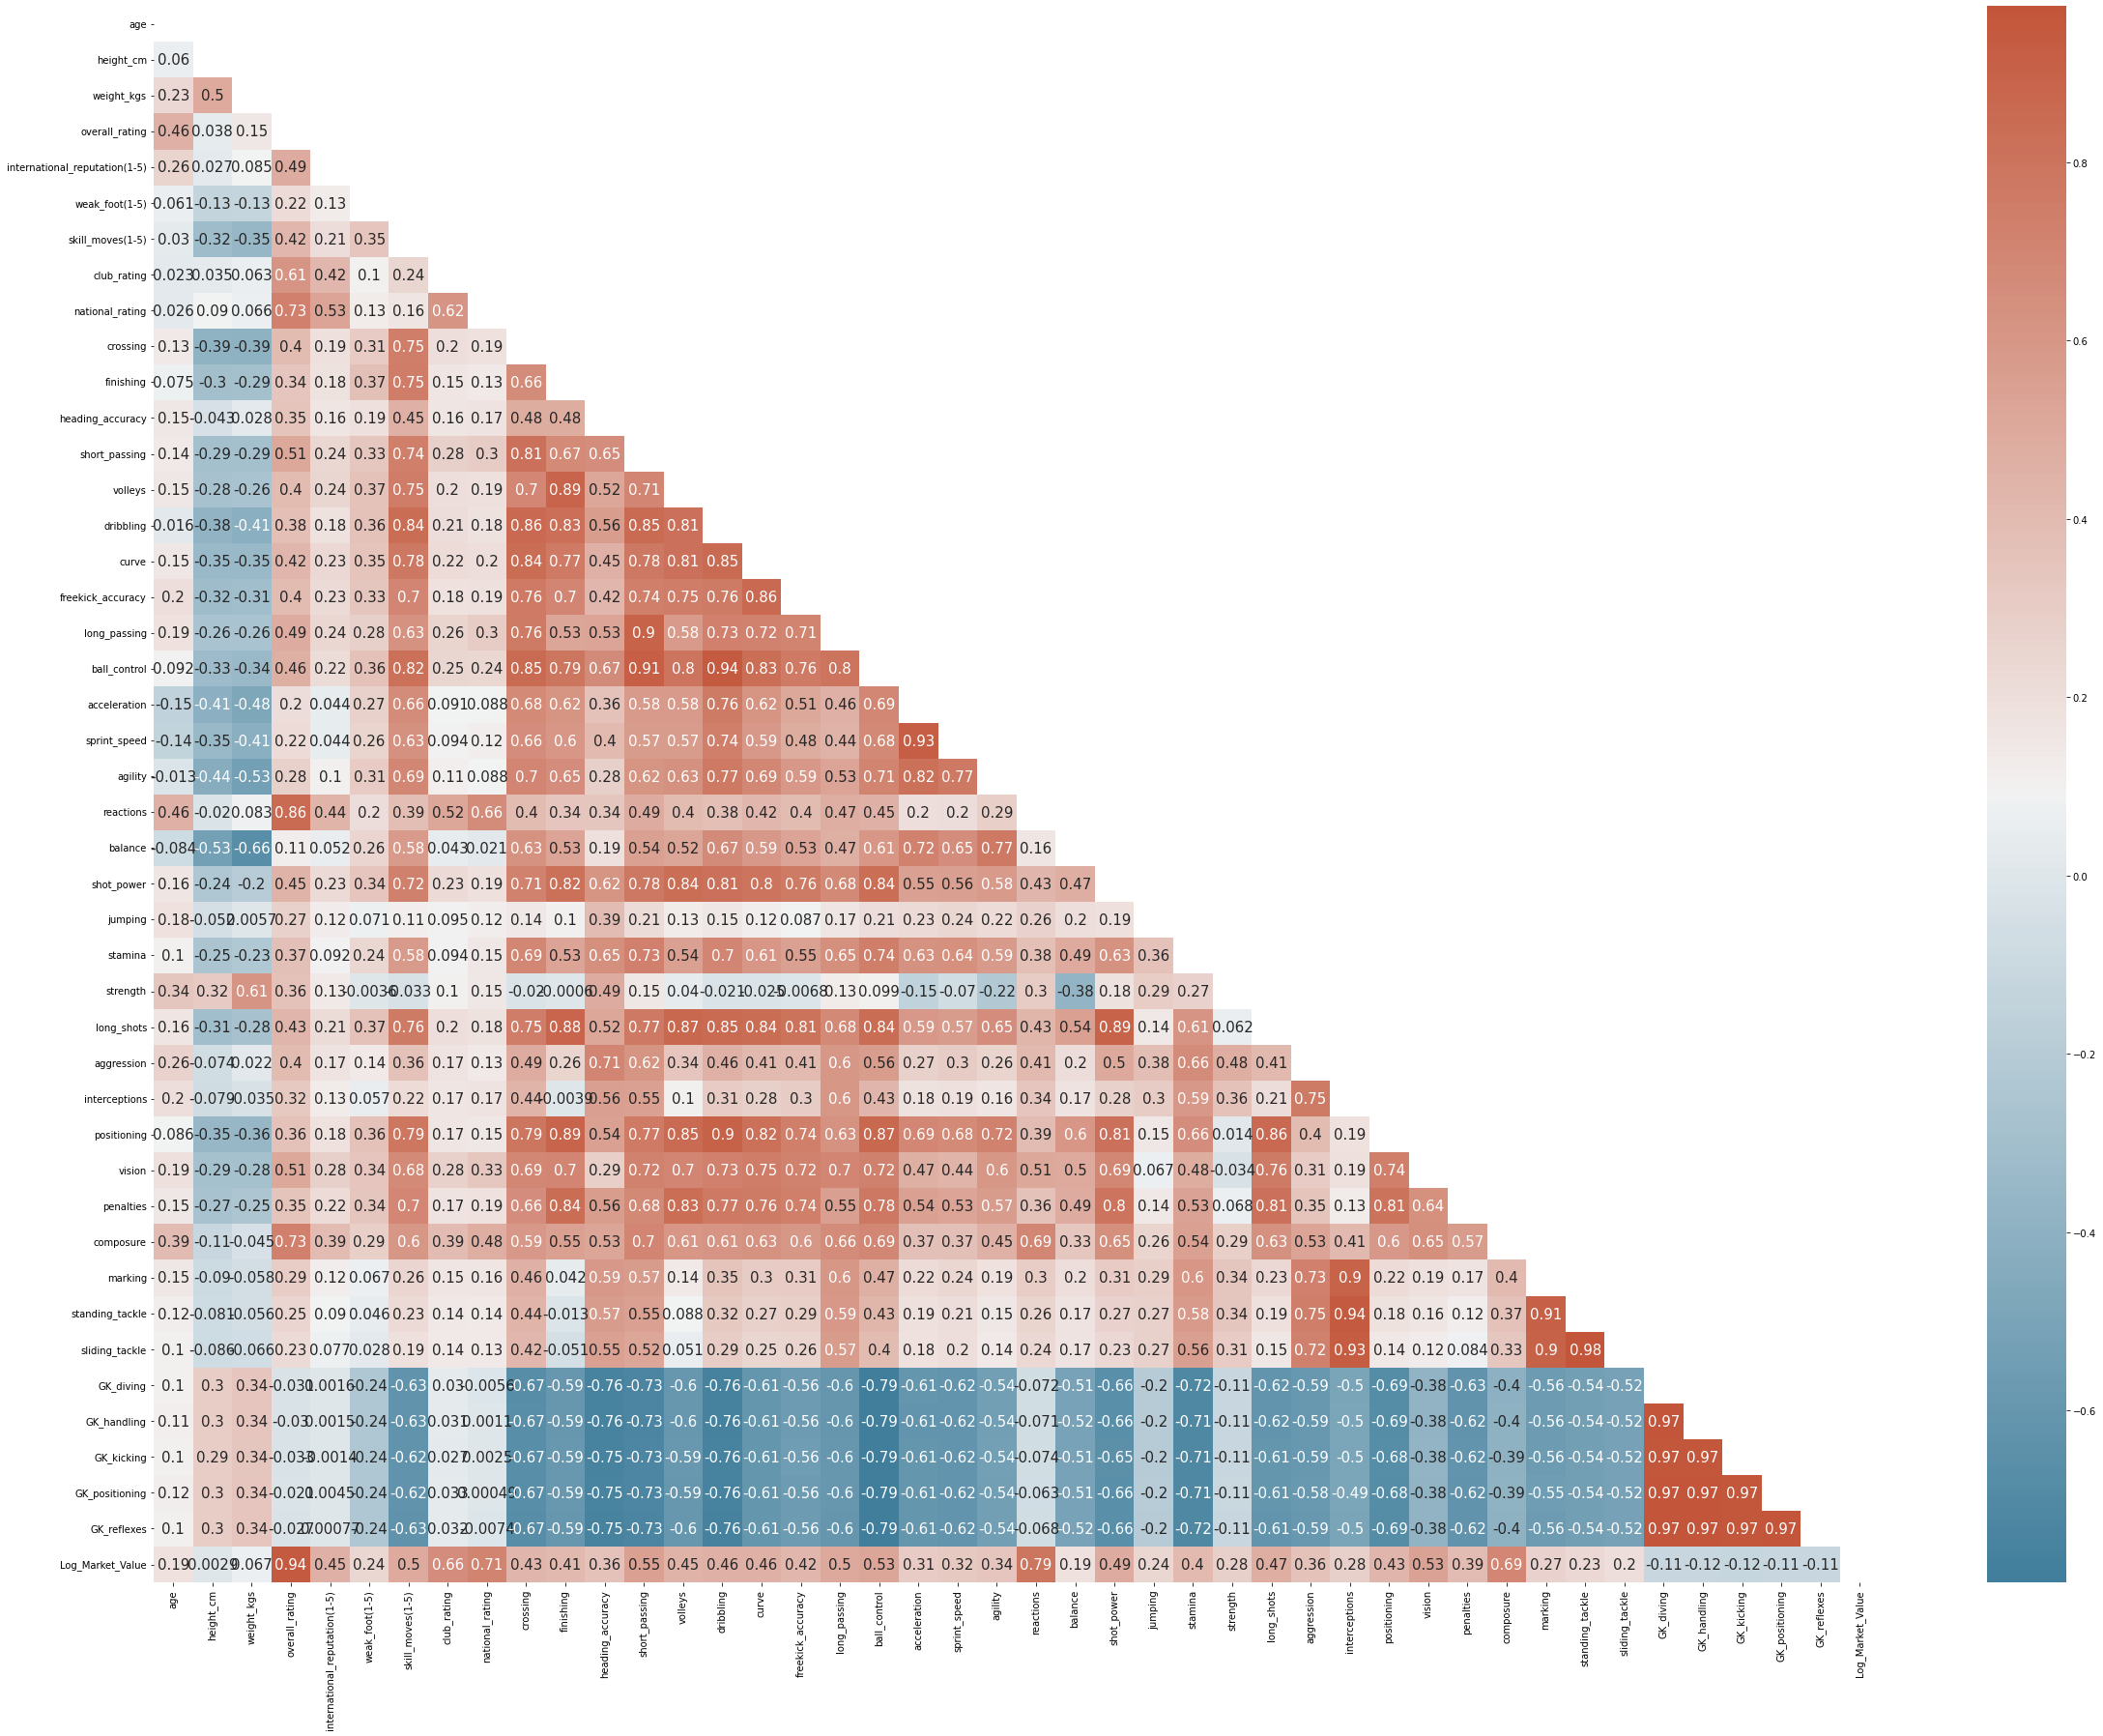

In [18]:
corr= df_plot.corr()
f, ax = plt.subplots(figsize=(40, 30))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sb.diverging_palette(230, 20, as_cmap=True)
sb.heatmap(corr, annot=True, mask = mask, cmap=cmap,annot_kws={"size":15})

Dalla matrice delle correlazioni si nota come le feature che hanno il maggior impatto sul Valore di mercato del Giocatore siano il Rating Generale, la reputazione internazionale, la reputazione del club, la reputazione della Nazionale, la Capacità di Reazione ed il temperamento. Per la variabile Rating Generale siamo quasi alla collinearità ma non viene estromessa dal processo di analisi. 

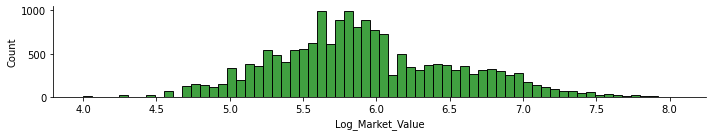

In [19]:
plot1 = sb.displot(df_plot['Log_Market_Value'],height=2,aspect=5,color='green') 

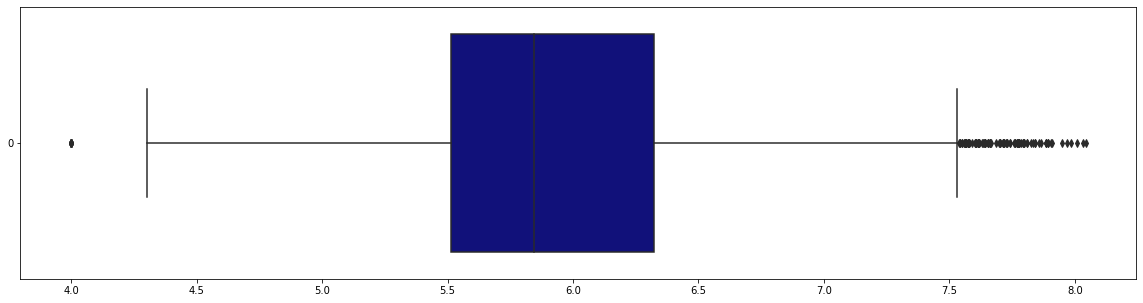

In [20]:
bp1 = sb.boxplot(data=df_plot['Log_Market_Value'],color='darkblue',orient='h')
bp1.figure.set_size_inches(20,5)


Nel boxplot possiamo subito vedere che siamo in presenza di alcuni valori che possono essere visti come outlier, in particolare le osservazioni vicino al valore 8. La maggiore parte dei valori ricadono nell'intervallo tra 4,25 e 7,5.

In [21]:
df_plot = df_plot.groupby("preferred_foot")["name"].count()
df_plot

preferred_foot
Left      4173
Right    13781
Name: name, dtype: int64

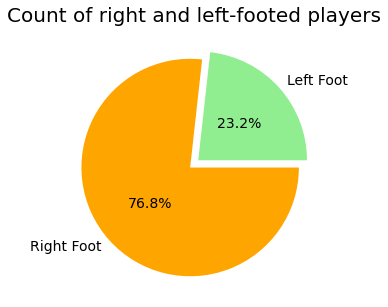

In [22]:
df_plot.plot.pie(autopct="%.1f%%", explode=[0.05]*2, pctdistance=0.5,labels=["Left Foot","Right Foot"],
                  ylabel="",figsize=(6, 5),textprops={'fontsize': 14},colors=('lightgreen', 'orange'))
plt.title("Count of right and left-footed players", fontsize=20);
plt.show()

Si evidenza che i giocatori mancini siano poco meno di un quarto dei giocatori totali, valore compatibile con la realtà.

### Convert to vector column first

In [23]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors

### Preparazione per la regressione

In [24]:
Indexer = StringIndexer(inputCol='preferred_foot', 
                        outputCol='preferred_foot_NDX',handleInvalid='skip')
OHEncoder = OneHotEncoder(inputCol='preferred_foot_NDX',
                        outputCol='preferred_foot_ENC')
Assembler = VectorAssembler(inputCols = ['age', 'height_cm', 'weight_kgs', 'overall_rating', 
                                             'international_reputation(1-5)', 'weak_foot(1-5)', 
                                             'skill_moves(1-5)', 'club_rating', 'national_rating', 
                                             'crossing', 'finishing', 'heading_accuracy', 'short_passing', 'volleys', 
                                             'dribbling', 'curve', 'freekick_accuracy', 'long_passing', 'ball_control', 
                                             'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power', 
                                             'jumping', 'stamina', 'strength', 'long_shots', 'aggression', 'interceptions', 
                                             'positioning', 'vision', 'penalties', 'composure', 'marking', 'standing_tackle', 
                                             'sliding_tackle', 'GK_diving', 'GK_handling', 'GK_kicking', 'GK_positioning', 
                                             'GK_reflexes',"preferred_foot_ENC"], 
                            outputCol='features',handleInvalid='skip')

In [25]:
pipeline = Pipeline(stages=[Indexer, OHEncoder, Assembler]) 

In [26]:
data = pipeline.fit(df_log).transform(df_log)

In [27]:
data.printSchema()

root
 |-- name: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- height_cm: double (nullable = true)
 |-- weight_kgs: double (nullable = true)
 |-- overall_rating: integer (nullable = true)
 |-- preferred_foot: string (nullable = true)
 |-- international_reputation(1-5): integer (nullable = true)
 |-- weak_foot(1-5): integer (nullable = true)
 |-- skill_moves(1-5): integer (nullable = true)
 |-- club_rating: double (nullable = true)
 |-- national_rating: double (nullable = true)
 |-- crossing: integer (nullable = true)
 |-- finishing: integer (nullable = true)
 |-- heading_accuracy: integer (nullable = true)
 |-- short_passing: integer (nullable = true)
 |-- volleys: integer (nullable = true)
 |-- dribbling: integer (nullable = true)
 |-- curve: integer (nullable = true)
 |-- freekick_accuracy: integer (nullable = true)
 |-- long_passing: integer (nullable = true)
 |-- ball_control: integer (nullable = true)
 |-- acceleration: integer (nullable = true)
 |-- sprint_spee

In [28]:
data.select("preferred_foot","preferred_foot_ENC","preferred_foot_NDX","Log_Market_Value").show(10)

+--------------+------------------+------------------+------------------+
|preferred_foot|preferred_foot_ENC|preferred_foot_NDX|  Log_Market_Value|
+--------------+------------------+------------------+------------------+
|          Left|         (1,[],[])|               1.0|  8.04336227802113|
|         Right|     (1,[0],[1.0])|               0.0| 7.841984804590114|
|         Right|     (1,[0],[1.0])|               0.0| 7.863322860120456|
|         Right|     (1,[0],[1.0])|               0.0| 7.792391689498254|
|         Right|     (1,[0],[1.0])|               0.0|  7.77451696572855|
|         Right|     (1,[0],[1.0])|               0.0|7.9084850188786495|
|         Right|     (1,[0],[1.0])|               0.0|7.8095597146352675|
|         Right|     (1,[0],[1.0])|               0.0|  7.57978359661681|
|         Right|     (1,[0],[1.0])|               0.0| 7.778151250383644|
|         Right|     (1,[0],[1.0])|               0.0| 7.711807229041191|
+--------------+------------------+---

## Split the dataset, create the regressor and train the model

In [29]:
assembled_df = data.select(['features', 'Log_Market_Value'])
assembled_df.show(3)

+--------------------+-----------------+
|            features| Log_Market_Value|
+--------------------+-----------------+
|[31.0,170.18,72.1...| 8.04336227802113|
|[27.0,154.94,76.2...|7.841984804590114|
|[25.0,190.5,83.9,...|7.863322860120456|
+--------------------+-----------------+
only showing top 3 rows



In [30]:
splits = data.randomSplit([0.7, 0.3])
seed = 42
train_df = splits[0]
test_df = splits[1]

In [31]:
print(train_df)

DataFrame[name: string, age: int, height_cm: double, weight_kgs: double, overall_rating: int, preferred_foot: string, international_reputation(1-5): int, weak_foot(1-5): int, skill_moves(1-5): int, club_rating: double, national_rating: double, crossing: int, finishing: int, heading_accuracy: int, short_passing: int, volleys: int, dribbling: int, curve: int, freekick_accuracy: int, long_passing: int, ball_control: int, acceleration: int, sprint_speed: int, agility: int, reactions: int, balance: int, shot_power: int, jumping: int, stamina: int, strength: int, long_shots: int, aggression: int, interceptions: int, positioning: int, vision: int, penalties: int, composure: int, marking: int, standing_tackle: int, sliding_tackle: int, GK_diving: int, GK_handling: int, GK_kicking: int, GK_positioning: int, GK_reflexes: int, Log_Market_Value: double, preferred_foot_NDX: double, preferred_foot_ENC: vector, features: vector]


## LINEAR REGRESSION

In [32]:
from pyspark.ml.regression import LinearRegression 
from pyspark.ml.evaluation import RegressionEvaluator

In [33]:
lr = LinearRegression(featuresCol ='features',labelCol='Log_Market_Value') #,maxIter=5, regParam=0.2, elasticNetParam=0.7

In [34]:
lr_model = lr.fit(train_df)
trainingSummary = lr_model.summary

In [35]:
print("Coefficients: " + str(lr_model.coefficients))

Coefficients: [-0.029276437150234806,9.568729782254915e-05,0.0008618253765281229,0.09101101001632013,-0.05975262282352532,-0.002500918943062075,-0.0027236721597234457,-0.00011974317493886793,-0.0028406161390924283,-0.000794147266065035,-0.00015112284740973988,-6.540248902325239e-05,0.002054018558556118,0.0006849545698131566,0.00038684880376003636,-0.0004934211242382136,0.00033222390554705583,0.00011402244272376483,0.0011858351769026213,-0.0002825250421546771,0.0007134262870914872,-0.0018313255505855394,0.0006958413364736112,0.0007771028635180191,0.00026604631943508546,-0.00029320486635606976,5.363536555811203e-05,0.00039277280197693907,0.0005275596456338309,0.0009154469438056429,0.00013739577740195716,0.0004565651936571593,0.0006136834148423612,0.00038070068132340637,-1.8887625530121306e-05,-0.0009387230471107603,-4.54638663994085e-05,-0.0005263410395681329,0.0013327363985086841,-0.0006182673839790176,-0.0018674755057267957,0.0010218073136216196,0.0008724524397139971,-0.002813284303895

In [36]:
print("Intercept: " + str(lr_model.intercept))
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)
train_df.describe().show()

Intercept: 0.5712644056303476
RMSE: 0.091072
r2: 0.970299
+-------+--------+------------------+------------------+-----------------+-----------------+--------------+-----------------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|summary|    name|               age|         height_

In [37]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","Log_Market_Value","features").show(5) #features_assembled
lr_evaluator = RegressionEvaluator(predictionCol="prediction",labelCol="Log_Market_Value",metricName="r2")
test_result = lr_model.evaluate(test_df)

+------------------+------------------+--------------------+
|        prediction|  Log_Market_Value|            features|
+------------------+------------------+--------------------+
| 7.929306582632738| 7.892094602690481|[27.0,175.26,73.0...|
| 6.581394888321559|6.2552725051033065|[36.0,187.96,83.0...|
| 7.228405918944312| 7.243038048686294|[24.0,185.42,76.2...|
|6.1385193196007135| 6.113943352306837|[31.0,187.96,78.0...|
|6.3767352934911035|6.3222192947339195|[23.0,195.5799999...|
+------------------+------------------+--------------------+
only showing top 5 rows



In [38]:
trainingSummary.residuals.show(5)

+--------------------+
|           residuals|
+--------------------+
|0.006621119767388883|
| 0.09059582959592305|
|-0.00493225359526...|
|-0.02324710434807642|
|-0.14313993548532888|
+--------------------+
only showing top 5 rows



In [39]:
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))

R Squared (R2) on test data = 0.966233
Root Mean Squared Error (RMSE) on test data = 0.102502
numIterations: 1
objectiveHistory: [0.0]


In [40]:
predictions = lr_model.transform(test_df)
predictions.show(1) #features_assembled
predictions.filter('prediction < 0').count() /df.count()   # il test set presenta lo 0% di valori negativi

+------------+---+---------+----------+--------------+--------------+-----------------------------+--------------+----------------+-----------+---------------+--------+---------+----------------+-------------+-------+---------+-----+-----------------+------------+------------+------------+------------+-------+---------+-------+----------+-------+-------+--------+----------+----------+-------------+-----------+------+---------+---------+-------+---------------+--------------+---------+-----------+----------+--------------+-----------+-----------------+------------------+------------------+--------------------+-----------------+
|        name|age|height_cm|weight_kgs|overall_rating|preferred_foot|international_reputation(1-5)|weak_foot(1-5)|skill_moves(1-5)|club_rating|national_rating|crossing|finishing|heading_accuracy|short_passing|volleys|dribbling|curve|freekick_accuracy|long_passing|ball_control|acceleration|sprint_speed|agility|reactions|balance|shot_power|jumping|stamina|strength|

0.0

In [41]:
test_target_s = test_df.select('Log_Market_Value')
target_points_s = [item.Log_Market_Value for item in test_target_s.collect() ]
target_points_s[:10]

[7.892094602690481,
 6.2552725051033065,
 7.243038048686294,
 6.113943352306837,
 6.3222192947339195,
 5.698970004336019,
 5.477121254719663,
 6.491361693834273,
 6.041392685158225,
 7.841984804590114]

RMSE: 0.0973704
r2: 0.960327

### Rappresentazione grafica

In [42]:
pred_points = [ item.prediction for item in predictions.collect() ]

Text(0, 0.5, 'Pred Points')

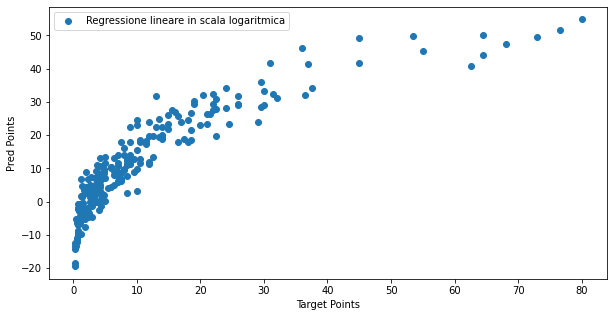

In [100]:
scatteplot_lr_ns= plt.scatter(target_points_s, pred_points)  #x,y
scatteplot_lr_ns.figure.set_size_inches(10,5)
plt.legend(["Regressione lineare in scala logaritmica"],loc='upper left')
plt.xlabel('Target Points')
plt.ylabel('Pred Points')

Si può osservare una variabilità bassa in generale nel modello, va anche ricordato, che i valori sono in scala logaritmica adesso. La distribuzione ricalca da vicino una regressione lineare.

Il modello risultante presenta degli ottimi risultati: RMSE: 0.0973704 ed R2: 0.960327

## DECISION TREE REGRESSION

In [54]:
from pyspark.ml.regression import DecisionTreeRegressor

In [55]:
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'Log_Market_Value') #features_assembled

In [56]:
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)

In [57]:
dt_evaluator = RegressionEvaluator(labelCol="Log_Market_Value", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)

In [58]:
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
dt_model.featureImportances
dtPred = dt_model.transform(test_df)

Root Mean Squared Error (RMSE) on test data = 0.131702


### Rappresentazione grafica

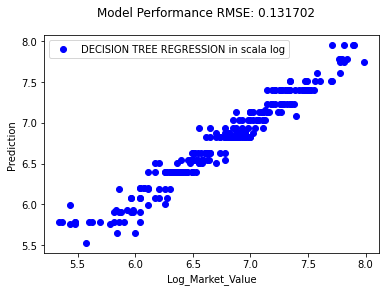

In [60]:
dtResult = dtPred.toPandas()
plt.plot(dtResult.Log_Market_Value, dtResult.prediction, 'bo')
plt.xlabel('Log_Market_Value')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.legend(["DECISION TREE REGRESSION in scala log"],loc='upper left')
plt.show()

Risulta presente una certa variabilità con il Decision Tree. In questo caso però abbiamo un RMSE di 0.125508, che, rispetto al 0.0973704 della regressione lineare su dati non scalati, rappresenta un leggero aumento. 

Si nota una certa variabilità per i valori minimi della scala logaritmica.

## GRADIENT-BOOSTED TREE REGRESSION

In [61]:
from pyspark.ml.regression import GBTRegressor

In [62]:
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'Log_Market_Value', maxIter=10) #

In [63]:
gbt_model = gbt.fit(train_df)

In [64]:
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'Log_Market_Value', 'features').show(5) #features_assembled
gbt_evaluator = RegressionEvaluator(labelCol="Log_Market_Value",
                                    predictionCol="prediction", metricName="rmse")

+-----------------+------------------+--------------------+
|       prediction|  Log_Market_Value|            features|
+-----------------+------------------+--------------------+
|7.952283600942856| 7.892094602690481|[27.0,175.26,73.0...|
|6.297473785779023|6.2552725051033065|[36.0,187.96,83.0...|
|7.191879152975972| 7.243038048686294|[24.0,185.42,76.2...|
|6.130955197310902| 6.113943352306837|[31.0,187.96,78.0...|
|6.404718430746678|6.3222192947339195|[23.0,195.5799999...|
+-----------------+------------------+--------------------+
only showing top 5 rows



In [65]:
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.113004


In [66]:
gbtPred = gbt_model.transform(test_df)

### Rappresentazione grafica

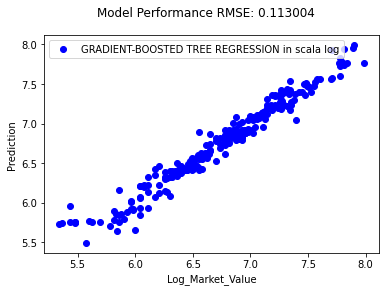

In [67]:
gbtResult = gbtPred.toPandas()
plt.plot(gbtResult.Log_Market_Value, gbtResult.prediction, 'bo')
plt.xlabel('Log_Market_Value')
plt.legend(["GRADIENT-BOOSTED TREE REGRESSION in scala log"],loc='upper left')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

Risulta ancora evidente una certa variabilità, soprattutto nei valori minimi, con il Gradient-Boosted Tree. In questo caso però abbiamo un RMSE di 0.112361, che, rispetto ai valori della regressione lineare rappresenta un leggero peggioramento e, rispetto al Decision Tree Regression, rappresenta un minimo miglioramento.

# Non-Log Scaled features in [0,1]

In [68]:
from pyspark.ml.feature import MinMaxScaler

In [69]:
data_nl = pipeline.fit(df_plain).transform(df_plain)

In [70]:
data_nl.select("preferred_foot","preferred_foot_ENC","preferred_foot_NDX","Market_Value_in_Million").show(10)

+--------------+------------------+------------------+-----------------------+
|preferred_foot|preferred_foot_ENC|preferred_foot_NDX|Market_Value_in_Million|
+--------------+------------------+------------------+-----------------------+
|          Left|         (1,[],[])|               1.0|                  110.5|
|         Right|     (1,[0],[1.0])|               0.0|                   69.5|
|         Right|     (1,[0],[1.0])|               0.0|                   73.0|
|         Right|     (1,[0],[1.0])|               0.0|                   62.0|
|         Right|     (1,[0],[1.0])|               0.0|                   59.5|
|         Right|     (1,[0],[1.0])|               0.0|                   81.0|
|         Right|     (1,[0],[1.0])|               0.0|                   64.5|
|         Right|     (1,[0],[1.0])|               0.0|                   38.0|
|         Right|     (1,[0],[1.0])|               0.0|                   60.0|
|         Right|     (1,[0],[1.0])|               0.

In [71]:
assembled_df_nl = data_nl.select(['features', 'Market_Value_in_Million'])
assembled_df_nl.show(3)

+--------------------+-----------------------+
|            features|Market_Value_in_Million|
+--------------------+-----------------------+
|[31.0,170.18,72.1...|                  110.5|
|[27.0,154.94,76.2...|                   69.5|
|[25.0,190.5,83.9,...|                   73.0|
+--------------------+-----------------------+
only showing top 3 rows



In [72]:
splits = data_nl.randomSplit([0.7, 0.3])
seed = 43
train_df_nl = splits[0]
test_df_nl = splits[1]

In [73]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features") 

In [74]:
scaled = scaler.fit(assembled_df_nl).transform(assembled_df_nl)

In [75]:
scaled.show(5)

+--------------------+-----------------------+--------------------+
|            features|Market_Value_in_Million|     scaled_features|
+--------------------+-----------------------+--------------------+
|[31.0,170.18,72.1...|                  110.5|[0.61904761904761...|
|[27.0,154.94,76.2...|                   69.5|[0.42857142857142...|
|[25.0,190.5,83.9,...|                   73.0|[0.33333333333333...|
|[27.0,162.56,59.0...|                   62.0|[0.42857142857142...|
|[27.0,193.04,92.1...|                   59.5|[0.42857142857142...|
+--------------------+-----------------------+--------------------+
only showing top 5 rows



In [76]:
scaled = scaled.select("scaled_features","Market_Value_in_Million")

In [77]:
scaled.show(5)

+--------------------+-----------------------+
|     scaled_features|Market_Value_in_Million|
+--------------------+-----------------------+
|[0.61904761904761...|                  110.5|
|[0.42857142857142...|                   69.5|
|[0.33333333333333...|                   73.0|
|[0.42857142857142...|                   62.0|
|[0.42857142857142...|                   59.5|
+--------------------+-----------------------+
only showing top 5 rows



## LINEAR REGRESSION

In [78]:
assembled_df_nl = scaled.select(['scaled_features', 'Market_Value_in_Million'])
assembled_df_nl.show(3)

+--------------------+-----------------------+
|     scaled_features|Market_Value_in_Million|
+--------------------+-----------------------+
|[0.61904761904761...|                  110.5|
|[0.42857142857142...|                   69.5|
|[0.33333333333333...|                   73.0|
+--------------------+-----------------------+
only showing top 3 rows



In [79]:
splits_s = assembled_df_nl.randomSplit([0.7, 0.3])
train_df_nl = splits_s[0]
test_df_nl = splits_s[1]

In [80]:
scaled_lr = LinearRegression(featuresCol = 'scaled_features', labelCol='Market_Value_in_Million') #, maxIter=10, regParam=0.3, elasticNetParam=0.8
scaled_lr_model = scaled_lr.fit(train_df_nl)
trainingSummary_lr_s = scaled_lr_model.summary

In [81]:
print("Coefficients: " + str(scaled_lr_model.coefficients))
print("Intercept: " + str(scaled_lr_model.intercept))
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)
train_df_nl.describe().show()

Coefficients: [-22.13099675977604,1.3928164672035672,2.492468338690396,71.17345094709646,24.782152911624244,-1.1455653126822243,-0.9403403067108262,-3.4521504027264163,-4.467263254871762,1.9041811150372698,7.558221855219725,-1.2395282516104384,-3.674328558256597,0.08519683676660522,-16.341365033713423,-1.2286032638177313,3.1644402055479057,9.821896410568442,-14.34917252172754,7.888652110234291,-4.3451275533825875,-0.17345345107005875,9.913030263858053,5.017870792211716,-13.698408546581787,-1.7950907401697902,8.64984167449201,-1.616113792464696,4.598144624944534,-4.989434165882787,-1.251420657132691,0.5799389882972094,-2.2345742770932677,-1.1223475158328466,3.977041350211232,-0.39054439935689045,-8.495226623813513,1.6744693386829679,-2.3001377619852166,-11.396111297593022,0.6061178998777881,-4.72837286351971,-7.010501712943124,-0.656823423209052]
Intercept: 1.6877166284753862
RMSE: 0.091072
r2: 0.970299
+-------+-----------------------+
|summary|Market_Value_in_Million|
+-------+-------

In [82]:
scaled_lr_predictions = scaled_lr_model.transform(test_df_nl)
scaled_lr_predictions.select("prediction","Market_Value_in_Million","scaled_features").show(5)
scaled_lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Market_Value_in_Million",metricName="r2")
test_result_s = scaled_lr_model.evaluate(test_df_nl)

+-------------------+-----------------------+--------------------+
|         prediction|Market_Value_in_Million|     scaled_features|
+-------------------+-----------------------+--------------------+
|  -8.83589742835942|                    0.8|[0.04761904761904...|
| -1.408972119152622|                    1.1|[0.04761904761904...|
| 10.680994576480218|                    4.2|[0.09523809523809...|
|-14.193381304981418|                   0.23|[0.09523809523809...|
| 18.134758415400416|                   11.5|[0.14285714285714...|
+-------------------+-----------------------+--------------------+
only showing top 5 rows



In [83]:
trainingSummary_lr_s.residuals.show(5)

+-------------------+
|          residuals|
+-------------------+
|  8.735374106534165|
| 27.550414384948645|
| 12.134016051341833|
|-2.0739074446818933|
| 15.225061532645082|
+-------------------+
only showing top 5 rows



In [84]:
print("R Squared (R2) on test data = %g" % scaled_lr_evaluator.evaluate(scaled_lr_predictions))
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)
print("numIterations: %d" % trainingSummary_lr_s.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary_lr_s.objectiveHistory))

R Squared (R2) on test data = 0.743702
Root Mean Squared Error (RMSE) on test data = 0.102502
numIterations: 1
objectiveHistory: [0.0]


In [85]:
scaled_lr_predictions.select("prediction","Market_Value_in_Million").show(5) #,"scaled_features"

+-------------------+-----------------------+
|         prediction|Market_Value_in_Million|
+-------------------+-----------------------+
|  -8.83589742835942|                    0.8|
| -1.408972119152622|                    1.1|
| 10.680994576480218|                    4.2|
|-14.193381304981418|                   0.23|
| 18.134758415400416|                   11.5|
+-------------------+-----------------------+
only showing top 5 rows



In [86]:
test_target_s = test_df_nl.select('Market_Value_in_Million')
target_points_s = [ item.Market_Value_in_Million for item in test_target_s.collect() ]
target_points_s[:10]

[0.8, 1.1, 4.2, 0.23, 11.5, 0.3, 29.0, 0.7, 22.5, 4.3]

In [87]:
pred_points = [ item.prediction for item in scaled_lr_predictions.collect() ]
scaled_lr_predictions.filter('prediction < 0').count() /assembled_df_nl.count()  


0.07701283547257877

Il 4,5% delle previsioni presenta dei valori predetti inferiori a 0, dovuto probabilmente alle poche osservazioni oppure al valore dell'R2 inferiore a quello in scala logaritmica. 

### Rappresentazione grafica

Text(0, 0.5, 'Pred Points')

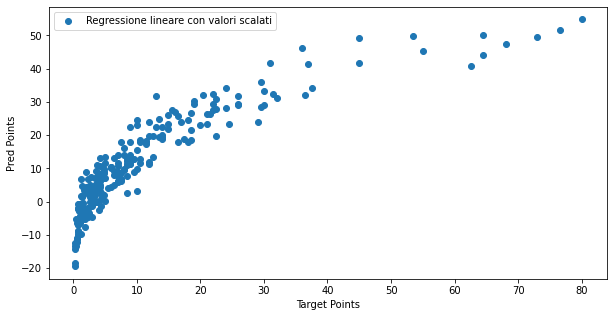

In [88]:
scatteplot_lr_s = plt.scatter(target_points_s, pred_points) 
scatteplot_lr_s.figure.set_size_inches(10,5)
plt.legend(["Regressione lineare con valori scalati"],loc='upper left')
plt.xlabel('Target Points')
plt.ylabel('Pred Points')

La regressione lineare con le feature scalate performa in maniera decisamente peggiore rispetto a quello che utilizza la scala logaritmica:
RMSE: 0.107183 contro 0.0973704, ma con un R2 leggermente superiore: 
R2: 0.776803 contro 0.960327. 

La distributzione presenta una variabilità crescente soprattutto nei valori medi. 

## DECISION TREE REGRESSION

In [89]:
dt1 = DecisionTreeRegressor(featuresCol ='scaled_features', labelCol = 'Market_Value_in_Million')
dt_model_s = dt1.fit(train_df_nl)
dt_predictions_s = dt_model_s.transform(test_df_nl)
dt_evaluator_s = RegressionEvaluator(labelCol="Market_Value_in_Million", predictionCol="prediction", metricName="rmse")

In [90]:
rmse = dt_evaluator_s.evaluate(dt_predictions_s)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
dt_model_s.featureImportances

Root Mean Squared Error (RMSE) on test data = 4.281


SparseVector(44, {0: 0.0251, 1: 0.0071, 2: 0.0009, 3: 0.8143, 9: 0.0031, 18: 0.0314, 21: 0.0009, 22: 0.0963, 24: 0.0047, 26: 0.002, 32: 0.0129, 33: 0.0014})

In [91]:
dtPred = dt_model_s.transform(test_df_nl)

#### Rappresentazione grafica

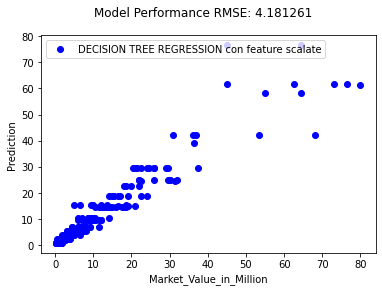

In [101]:
dtResult = dtPred.toPandas()
plt.plot(dtResult.Market_Value_in_Million, dtResult.prediction, 'bo')
plt.xlabel('Market_Value_in_Million')
plt.legend(["DECISION TREE REGRESSION con feature scalate"],loc='upper left')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

Risulta ancora evidente una certa variabilità. In questo caso però abbiamo un RMSE di 4.79799, che risulta essere decisamente superiore a quello ricavato dai dati in scala logaritmica (0.125508).

## GRADIENT-BOOSTED TREE REGRESSION

In [94]:
gbt_s = GBTRegressor(featuresCol = 'scaled_features', labelCol = 'Market_Value_in_Million', maxIter=10)
gbt_model_s = gbt_s.fit(train_df_nl)

In [95]:
gbt_predictions_s = gbt_model_s.transform(test_df_nl)
gbt_predictions_s.select('prediction', 'Market_Value_in_Million', 'scaled_features').show(5)
gbt_evaluator_s = RegressionEvaluator(labelCol="Market_Value_in_Million", 
                                    predictionCol="prediction", metricName="rmse")

+------------------+-----------------------+--------------------+
|        prediction|Market_Value_in_Million|     scaled_features|
+------------------+-----------------------+--------------------+
|1.2080733368249343|                    0.8|[0.04761904761904...|
|1.3077715389208246|                    1.1|[0.04761904761904...|
|4.4838111061315145|                    4.2|[0.09523809523809...|
|0.7411846704071183|                   0.23|[0.09523809523809...|
|  8.64204888500573|                   11.5|[0.14285714285714...|
+------------------+-----------------------+--------------------+
only showing top 5 rows



In [96]:
rmse = gbt_evaluator_s.evaluate(gbt_predictions_s)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4.18126


In [97]:
gbtPred_s = gbt_model_s.transform(test_df_nl)

### Rappresentazione grafica

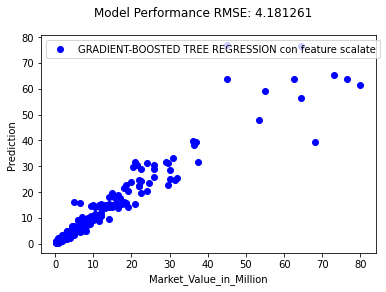

In [99]:
gbt_Result_s = gbtPred_s.toPandas()
plt.plot(gbt_Result_s.Market_Value_in_Million, gbt_Result_s.prediction, 'bo')
plt.xlabel('Market_Value_in_Million')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.legend(["GRADIENT-BOOSTED TREE REGRESSION con feature scalate"],loc='upper left')
plt.show()

In questo grafico si può notare una variabilità che aumenta in maniera esponenziale, abbiamo un RMSE di 6.99645, che risulta essere decisamente superiore a quello dei dati in scala logaritmica (0.112361).